In [1]:
# Imports
import random
import sys
import numpy as np
import time as t
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import model
from keijzer_exogan import *

# initialize random seeds
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)


"""
Local variables
"""
workers = 0 # Number of workers for dataloader, 0 when to_vram is enabled
batch_size = 1 # using one image ofcourse
image_size = 32
nz = 100 # size of latent vector
n_iters = 1*10**4 # number of iterations to do for inpainting
torch.backends.cudnn.benchmark=True # Uses udnn auto-tuner to find the best algorithm to use for your hardware, speeds up training by almost 50%
lr = 1e-2
lr_G = 2e-4
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
selected_gpus = [3] # Number of GPUs available. Use 0 for CPU mode.

path = '/datb/16011015/ExoGAN_data/selection//' #notice how you dont put the last folder in here...
images = np.load(path+'first_chunks_25_percent_images.npy')

print('Batch size: ', batch_size)


# Number of training epochs

# Learning rate for optimizers
ngpu = len(selected_gpus)
print('Number of GPUs used: ', ngpu)


"""
Load data and prepare DataLoader
"""
shuffle = True

if shuffle:
    np.random.shuffle(images) # shuffles the images

images = images[:int(len(images)*0.0000025)] # use only first ... percent of the data (0.05)
print('Number of images: ', len(images))

dataset = numpy_dataset(data=images, to_vram=True) # to_vram pins it to all GPU's
#dataset = numpy_dataset(data=images, to_vram=True, transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) # to_vram pins it to all GPU's

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=False)

"""
Load and setup models
"""
# Initialize cuda
device = torch.device("cuda:"+str(selected_gpus[0]) if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load models, set to evaluation mode since training is not needed (this also allows batchsize 1 to work with batchnorm2d layers)
netG = model.Generator(ngpu).eval().to(device)
netD = model.Discriminator(ngpu).eval().to(device)

# Apply weights
print('Loading weights...')
try:
    # Load saved weights
    netG.load_state_dict(torch.load('netG_state_dict2', map_location=device)) #net.module..load_... for parallel model , net.load_... for single gpu model
    netD.load_state_dict(torch.load('netD_state_dict2', map_location=device))
except:
    print('Could not load saved weights.')
    sys.exit()

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, device_ids=selected_gpus, output_device=device)
    netD = nn.DataParallel(netD, device_ids=selected_gpus, output_device=device)


"""
Define input training stuff (fancy this up)
"""
G = netG
D = netD
z = torch.randn(1, nz, 1, 1, requires_grad=True, device=device)

lamb = 3e-1

criteria = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # should be sgd
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

Batch size:  1
Number of GPUs used:  1
Number of images:  1
Loading weights...


# Show a generated image

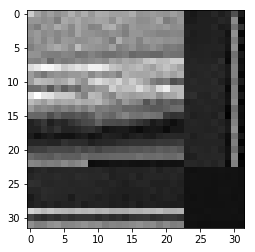

In [2]:
z2 = torch.randn(1, nz, 1, 1, device=device)
t = G(z2).detach().cpu()[0, 0, :, :]
# TODO: why does this already look real?
plt.imshow(t, cmap='gray') # plot the masked image 

# Inpainting
The corrupted image $y$ is mapped to the closest $z$ in the latent representation space, this mapping is denoted as $\hat{z}$.
    
$\hat{z} = \operatorname{arg\,min}_z \{ \mathcal{L}_c(z |y, M) + \mathcal{L}_p (z) \}$

where

$\mathcal{L}_c(z |y, M) = || M \bigodot G(z) - M \bigodot y||_1 = || M \bigodot (G(z)-y) ||_1 $

with $\mathcal{L}_c$ being contextual loss and $M$ being a binary mask with the same size as $y$,

$\mathcal{L}_p (z) = \lambda \operatorname{log}(1-D(G(z)))$

with $\mathcal{L}_p$ being perceptual loss and $D$ being the discriminator.
  
Once $G(\hat{z})$ is generated, the final solution $\hat{x}$ is calculated as

$\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$  

(substitute $x_i = y_i$ for $M_i = 1$).

-----

$|| ... ||$ is done by `torch.norm()`.  
$... \bigodot ...$ is done by `torch.mul()`.  
-----
TODO: Implement $\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$    
Currently $\hat{x} = G(\hat{z}) \bigodot (1 -M)+y$

In [3]:
# Lists to keep track of progress
real_images = []
masked_images= []
inpainted_images = []

In [ ]:
"""
Inpainting
"""
for i, data in enumerate(dataloader, 0): # batches per epoch
    real_cpu = data.to(device)
    b_size = real_cpu.size(0) # this is one ofc, it's one image we're trying to inpaint

    print("data.shape: ", data.shape)
    image = data.to(device) # select the image (Channel, Height, Width), this is the original unmasked input image
    real_images.append(image)
    print("image.shape: ", image.shape)

    """Mask the images manually, for testing pruposes"""
    mask = torch.ones(size=image.shape).to(device) # create mask with 1's in the shape of image
    
    print("mask.shape", mask.shape)

    # use a random 'easy' mask
    mask[:, :, 10:20, 5:15] = 0

    masked_image = torch.mul(image, mask).to(device) #image bigodot mask
    masked_images.append(masked_image)
    print('masked image shape', masked_image.shape)
    plt.imshow(masked_image.detach().cpu()[0, 0, :, :], cmap='gray') # plot the masked image

    opt = optim.Adam([z], lr=lr)

    # what's v and m?
    v = torch.tensor(0, dtype=torch.float32, device=device)
    m = torch.tensor(0, dtype=torch.float32, device=device)


    """Start the inpainting process"""
    for iteration in range(n_iters):
        if z.grad is not None:
            z.grad.data.zero_()

        G.zero_grad()
        D.zero_grad()


        image_generated = G(z) # generated image G(z)
        image_generated_masked = torch.mul(image_generated, mask) # G(z) bigodot M
        image_generated_inpainted = torch.mul(image_generated, (1-mask))+masked_image
        
        if (iteration % 100 == 0):
            inpainted_images.append(image_generated_inpainted)

        #print("image_generated_inpainted.shape : ",image_generated_inpainted.shape)

        t = image_generated_inpainted.detach().cpu()[0, 0, :, :]

        # TODO: why does this already look real?
        plt.imshow(t, cmap='gray') # plot the masked image 

        """Calculate losses"""
        loss_context = torch.norm(image_generated_masked-masked_image, p=1) #what's p=1?
        discriminator_output = netD(image_generated_inpainted)
        #print("Discriminator output: ", discriminator_output)

        labels = torch.full((b_size,), 1, device=device)
        loss_perceptual = torch.log(1-discriminator_output)
        
        #print(loss_perceptual.data.cpu().numpy().flatten()[0])

        total_loss = loss_context + lamb*loss_perceptual
        
        # grab the values from losses for printing
        loss_perceptual = loss_perceptual.data.cpu().numpy().flatten()[0]
        loss_context = loss_context.data.cpu().numpy().flatten()[0]



        total_loss.backward()
        opt.step()
        
        total_loss = total_loss.data.cpu().numpy().flatten()[0]
        
        print("\r iteration : {:4} , context_loss: {:.4f}, perceptual_loss: {:4f}, total_loss: {:4f}".format(iteration,loss_context,loss_perceptual, total_loss),end="")

data.shape:  torch.Size([1, 1, 32, 32])
image.shape:  torch.Size([1, 1, 32, 32])
mask.shape torch.Size([1, 1, 32, 32])
masked image shape torch.Size([1, 1, 32, 32])
 iteration : 4211 , context_loss: 99.7875, perceptual_loss: -0.005796, total_loss: 99.785751

# Show results

In [ ]:
real = real_images[0].detach().cpu()[0, 0, :, :]
real_masked = masked_images[0].detach().cpu()[0, 0, :, :]

first_generated =inpainted_images[1].detach().cpu()[0, 0, :, :]
last_generated = inpainted_images[-1].detach().cpu()[0, 0, :, :]



plt.figure(figsize=(22,10))

plt.subplot(1,4,1)
plt.imshow(real, cmap='gray')

plt.subplot(1,4,2)
plt.imshow(real_masked, cmap='gray')

plt.subplot(1,4,3)
plt.imshow(first_generated, cmap='gray')

plt.subplot(1,4,4)
plt.imshow(last_generated, cmap='gray')

plt.imshow

plt.tight_layout()

In [ ]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 20**128

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i.detach().cpu()[0, 0, :, :], animated=True, cmap='gray')] for i in inpainted_images]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())